# Luttinger Kohn Model of Particle in Box 
## Study of anisotropy of g-tensor

This Notebook studies the effect of asymmetric in-plane confinement on the g-tensor components in Germaium Heterostructures

### Model Setup

Loading relevant modules and setting up jupyter

In [1]:
try:
    import nqcpfem
except ModuleNotFoundError as err:
    import sys
        # put path to nqcpfem module here   
    src_path = '/mnt/c/Users/olisc/NQCP/NQCP_FEM/'
    sys.path.append(src_path)
    import nqcpfem
import sympy
sympy.init_printing(use_latex='mathjax')
import IPython.display as disp
from matplotlib import pyplot as plt
import numpy as np
import os

import logging
logging.getLogger().setLevel(logging.INFO)


Bare Luttinger-Kohn Hamiltonian

⎡ 2 ⎛           ⎛     2        2        2⎞                   2                
⎢h̅ ⋅⎝\gamma_{1}⋅⎝k_{x}  + k_{y}  + k_{z} ⎠ + \gamma_{2}⋅k_{x}  + \gamma_{2}⋅k
⎢─────────────────────────────────────────────────────────────────────────────
⎢                                                  2⋅m                        
⎢                                                                             
⎢                             2                                               
⎢             -√3⋅\gamma_{3}⋅h̅ ⋅(k_{x}⋅k_{z} + k_{z}⋅k_{x} + ⅈ⋅(k_{y}⋅k_{z} +
⎢             ────────────────────────────────────────────────────────────────
⎢                                                  2⋅m                        
⎢                                                                             
⎢            2 ⎛                2                   2                         
⎢       -√3⋅h̅ ⋅⎝\gamma_{2}⋅k_{x}  - \gamma_{2}⋅k_{y}  + ⅈ⋅\gamma_{3}⋅(k_{x}⋅k
⎢       ────────────────────────────────────────────

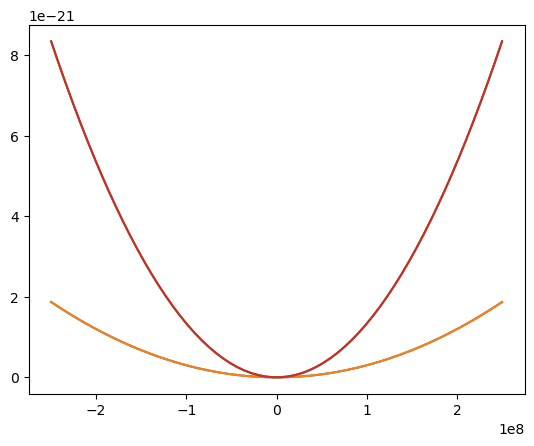

In [2]:
from nqcpfem.band_model import LuttingerKohnHamiltonian
bm = LuttingerKohnHamiltonian(spatial_dim=3).material_spec('Ge') # set coefficient to those of Winkler

# jupyter does not like \hbar so we have to change it to hbar when displaying the Hamiltonian
disp.display(bm.post_processed_array().subs({'\hbar':'hbar'}).simplify())

# plot spectrum as well
spectrum = bm.spectrum((-2.5e8,2.5e8),(1,0),64)
_=plt.plot(*spectrum)

adding z-confinement

⎡ 2 ⎛   2 ⎛                2                   2                   2          
⎢h̅ ⋅⎝l_z ⋅⎝\gamma_{1}⋅k_{x}  + \gamma_{1}⋅k_{y}  + \gamma_{2}⋅k_{x}  + \gamma
⎢─────────────────────────────────────────────────────────────────────────────
⎢                                                               2             
⎢                                                          2⋅l_z ⋅m           
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                             0               
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢               2 ⎛                  2              

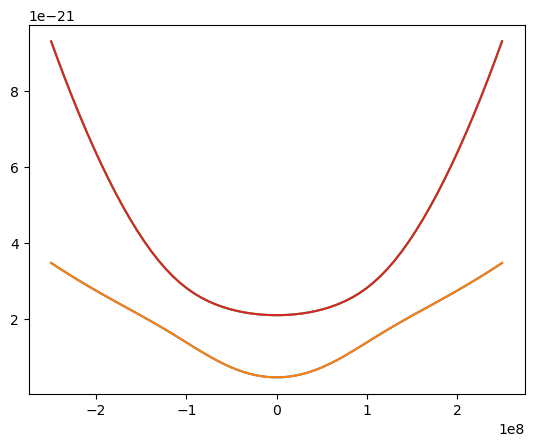

In [3]:
bm.add_z_confinement(nz_modes=1,z_confinement_type='box',lz=25e-9)


disp.display(bm.post_processed_array().subs({'\hbar':'hbar'}).simplify()[:,:,0,0])
spectrum = bm.spectrum(k_range=(-2.5e8,2.5e8),k_direction=(1,0),n_points=64)
_=plt.plot(*spectrum)

### Envelope Function Model
First, when using FEM, we have to make sure that the k-operators are correctly arranged:

In [4]:
bm.fix_k_arrangement('FEM')


We first define the domain (a rectangle)

In [5]:
from nqcpfem.envelope_function import RectangleDomain
domain = RectangleDomain(Lx=2e-7,Ly=1e-7,Lz=0) # 100 x 100 nm. Lz unimportant since our model is 2D
domain.resolution = [100,100] # resolution for the FEM model

Next we define the solver which will solve for the eigenstates of the envelope model

In [6]:
from nqcpfem.solvers import PETScSolver

# we want the 10 eigenstates which are closest to 0, so we look for eigenstates of small magnitude (SM) relative to sigma=0
solver = PETScSolver(k=10,which='SM',sigma=0)

#### FEM

In [7]:
from nqcpfem.fenics import FEniCsModel
# we pick piecewise linear functions as our basis: ('CG',1)
fem_model = FEniCsModel(band_model=bm,domain=domain,boundary_condition=0,function_class=('CG',1)) 

solving the model:

In [8]:
eigenvals,eigenvecs = solver.solve(fem_model)

INFO:root:running build_ext
INFO:root:building 'libffcx_forms_92336faa5e74be4ddc0e776c61a59b694797871e' extension
INFO:root:/home/oliver/miniconda3/envs/Germanium_Spins_FE/bin/x86_64-conda-linux-gnu-cc -Wno-unused-result -Wsign-compare -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /home/oliver/miniconda3/envs/Germanium_Spins_FE/include -fPIC -O2 -isystem /home/oliver/miniconda3/envs/Germanium_Spins_FE/include -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /home/oliver/miniconda3/envs/Germanium_Spins_FE/include -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /home/oliver/miniconda3/envs/Germanium_Spins_FE/include -fPIC -I/home/oliver/miniconda3/envs/Germanium_Spins_FE/lib/python3.10/site-packages/ffcx/codegeneration -I/home/oliver/miniconda3/envs/Germanium_Spins_FE/include/python3.10 -c libffcx_forms_92336faa5e74be4ddc0e776c61a59b694797871e.c -o ./libffcx_forms_92336faa5e74be4ddc0e776c61a59b694797871e.o -O2 -g0
INFO

In [9]:
# eigenvalues in meV
eigenvals*nqcpfem.UNIT_CONVENTION['J to eV']*1000 

array([3.76214559, 3.76214559, 4.23283228, 4.23283228, 4.99276901,
       4.99276901, 5.60185168, 5.60185168, 5.9993686 , 5.9993686 ,
       6.00802405, 6.00802405, 6.65649732])

##### Plotting the Eigenstates

In [10]:
from nqcpfem.plotting import plot_eigenvector
plot_eigenvector(eigenvecs[0]*0.2,fem_model,scaling=False)

INFO:root:awaiting runner setup
INFO:root:awaiting site startup
INFO:root:awaiting running future


Widget(value="<iframe src='http://localhost:33479/index.html?ui=P_0x7f5c19d74ac0_0&reconnect=auto' style='widt…

In [11]:
farr.shape

NameError: name 'farr' is not defined

INFO:aiohttp.access:127.0.0.1 [08/Aug/2023:08:24:19 +0000] "GET /index.html?ui=P_0x7f5c19d74ac0_0&reconnect=auto HTTP/1.1" 200 236 "-" "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Code/1.80.2 Chrome/108.0.5359.215 Electron/22.3.14 Safari/537.36"
INFO:aiohttp.access:127.0.0.1 [08/Aug/2023:08:24:19 +0000] "GET /vue.global.js HTTP/1.1" 200 253 "http://localhost:33479/index.html?ui=P_0x7f5c19d74ac0_0&reconnect=auto" "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Code/1.80.2 Chrome/108.0.5359.215 Electron/22.3.14 Safari/537.36"
INFO:aiohttp.access:127.0.0.1 [08/Aug/2023:08:24:19 +0000] "GET /js/chunk-vendors.ec946a94.js HTTP/1.1" 200 253 "http://localhost:33479/index.html?ui=P_0x7f5c19d74ac0_0&reconnect=auto" "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Code/1.80.2 Chrome/108.0.5359.215 Electron/22.3.14 Safari/537.36"
INFO:aiohttp.access:127.0.0.1 [08/Aug/2023:08:24:19 +0000] "GET /j

In [ ]:
plot_eigenvector(eigenvecs[2]*0.2,fem_model,scaling=False)

Widget(value="<iframe src='http://localhost:44515/index.html?ui=P_0x7f103f161f00_2&reconnect=auto' style='widt…

In [ ]:

plot_eigenvector(eigenvecs[6],fem_model)

Widget(value="<iframe src='http://localhost:46797/index.html?ui=P_0x7efff60707f0_2&reconnect=auto' style='widt…

### Box-modes

In [ ]:
bm.post_processed_array().subs('\hbar','hbar')

⎡⎡⎡            2      2               2      2        2             2         
⎢⎢⎢\gamma_{1}⋅h̅ ⋅k_{x}    \gamma_{1}⋅h̅ ⋅k_{y}    0.5⋅π ⋅\gamma_{1}⋅h̅    \ga
⎢⎢⎢──────────────────── + ──────────────────── + ──────────────────── + ──────
⎢⎢⎢        2⋅m                    2⋅m                      2                  
⎢⎣⎣                                                     l_z ⋅m                
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                 [[0]]       
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢       ⎡⎡                 2      2                 

In [ ]:
from nqcpfem.box_modes import BoxEFM


box_model = BoxEFM(bm,domain,10,10,None)


from scipy.linalg import eigh


In [ ]:
def box_search_func(lx):
    dom = RectangleDomain(lx,100e-9,25e-9)
    box_model.independent_vars['domain'] = dom
    
    A_box = box_model.assemble_array()
    sols = eigh(A_box,subset_by_index=[0,9],overwrite_a=True) # we only care about the 10 lowest ones
    
    return sols


In [ ]:
from nqcpfem.parameter_search import ParameterSearch
parameters = np.linspace(50e-9,200e-9,64)
box_search_save = 'box_basis_ly_fixed_LK.save'

#box_search = ParameterSearch(parameters,box_search_func,box_search_save)
box_search = ParameterSearch.load(box_search_save,box_search_func)

In [ ]:
box_search.run(True,False)

INFO:nqcpfem.parameter_search:evaluating at grid point 1/64
INFO:nqcpfem.parameter_search:evaluating at grid point 2/64
INFO:nqcpfem.parameter_search:evaluating at grid point 3/64
INFO:nqcpfem.parameter_search:evaluating at grid point 4/64
INFO:nqcpfem.parameter_search:evaluating at grid point 5/64
INFO:nqcpfem.parameter_search:evaluating at grid point 6/64
INFO:nqcpfem.parameter_search:evaluating at grid point 7/64
INFO:nqcpfem.parameter_search:evaluating at grid point 8/64
INFO:nqcpfem.parameter_search:evaluating at grid point 9/64
INFO:nqcpfem.parameter_search:evaluating at grid point 10/64
INFO:nqcpfem.parameter_search:evaluating at grid point 11/64
INFO:nqcpfem.parameter_search:evaluating at grid point 12/64
INFO:nqcpfem.parameter_search:evaluating at grid point 13/64
INFO:nqcpfem.parameter_search:evaluating at grid point 14/64
INFO:nqcpfem.parameter_search:evaluating at grid point 15/64
INFO:nqcpfem.parameter_search:evaluating at grid point 16/64
INFO:nqcpfem.parameter_search:eva

INFO:root:client 3d97098edd1f436b931da53b9718e80f disconnected
INFO:root:No more connections, scheduling shutdown
INFO:aiohttp.access:127.0.0.1 [07/Aug/2023:18:57:04 +0000] "GET /ws HTTP/1.1" 101 0 "-" "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Code/1.80.2 Chrome/108.0.5359.215 Electron/22.3.14 Safari/537.36"
INFO:root:client c571a2d560c9487a9ae4af547391d660 connected
INFO:root:client 8c841ce0693a44aaae9d4d561a79d94f connected
INFO:root:client 094ef2248a524d83a8fec6788b937e69 connected
INFO:root:client bb432eb2f88943a19e264172fbcfe1a4 connected


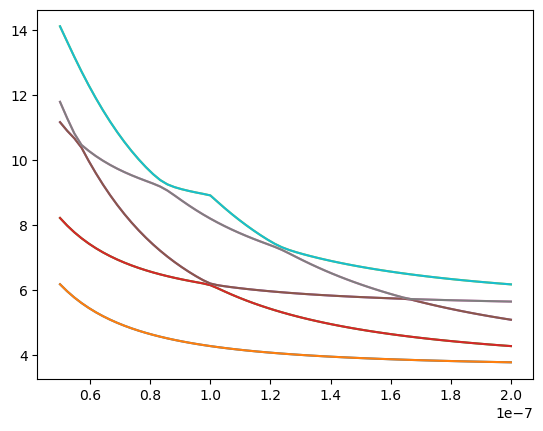

In [ ]:
x = box_search.parameter_sets
y = np.stack([r[0] for r in box_search._results_])*nqcpfem.UNIT_CONVENTION['J to eV']*1000
plt.plot(x,y)

In [ ]:
v = box_search._results_[-1][1][:,0]
vvec= box_model.eigensolutions_to_eigentensors(v)

XX,YY = np.meshgrid(np.linspace(-100e-9,100e-9),np.linspace(-50e-9,50e-9))
x=np.stack([XX.flatten(),YY.flatten()],axis=1)
x,vpos = box_model.positional_rep(vvec,x)


TypeError: 'NoneType' object cannot be interpreted as an integer

array([[0.+0.00000000e+00j, 0.+1.33333333e+09j, 0.+0.00000000e+00j],
       [0.-1.33333333e+09j, 0.+0.00000000e+00j, 0.+2.40000000e+09j],
       [0.+0.00000000e+00j, 0.-2.40000000e+09j, 0.+0.00000000e+00j]])

## G-matrix
We can compute the G-matrix from the ground state Kramer's pair of of the envelope model. 
First we need to add a magnetic field term to the Hamiltonian

In [ ]:
# not specifying any values of B since we do not need it for computing the g-matrix. 
# We still have to add a Zeeman term though because we need ot know which matrix elements are linear in B
bm.add_zeeman_term() 
disp.display(bm.post_processed_array().subs({'\hbar':'hbar'}).simplify()[:,:,0,0])

⎡               2                                                    2    2 ⎛ 
⎢- 3⋅\mu_{B}⋅l_z ⋅m⋅(4⋅κ⋅(B_{z})_{00}(x) + 9⋅q⋅(B_{z})_{00}(x)) + 2⋅h̅ ⋅l_z ⋅⎝
⎢─────────────────────────────────────────────────────────────────────────────
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                              √3⋅\mu_{B}⋅(-4⋅κ⋅(B_{x})_{00}(x
⎢                                              ───────────────────────────────
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                   

Note that the B-field is labeled as $(B_{x})_{00}(x)$ because the B-field is projected down onto the lowest z-mode

In [14]:
from nqcpfem.g_matrix import GMatrix
gmat = GMatrix(fem_model,solver) # the solver is needed to compute the Kramer's pair

matrix = gmat.matrix()
np.linalg.svd(matrix)

INFO:root:running build_ext
INFO:root:building 'libffcx_forms_55bc22eabffda5dfa68fb0728e418e19caaff754' extension
INFO:root:/home/oliver/miniconda3/envs/Germanium_Spins_FE/bin/x86_64-conda-linux-gnu-cc -Wno-unused-result -Wsign-compare -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /home/oliver/miniconda3/envs/Germanium_Spins_FE/include -fPIC -O2 -isystem /home/oliver/miniconda3/envs/Germanium_Spins_FE/include -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /home/oliver/miniconda3/envs/Germanium_Spins_FE/include -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /home/oliver/miniconda3/envs/Germanium_Spins_FE/include -fPIC -I/home/oliver/miniconda3/envs/Germanium_Spins_FE/lib/python3.10/site-packages/ffcx/codegeneration -I/home/oliver/miniconda3/envs/Germanium_Spins_FE/include/python3.10 -c libffcx_forms_55bc22eabffda5dfa68fb0728e418e19caaff754.c -o ./libffcx_forms_55bc22eabffda5dfa68fb0728e418e19caaff754.o -O2 -g0
INFO

(array([[-0.99366893,  0.00549767,  0.1122133 ],
        [ 0.11225591,  0.00817722,  0.99364568],
        [ 0.00454514,  0.99995145, -0.0087426 ]]),
 array([20.7932281 ,  2.30961049,  1.96592089]),
 array([[ 3.92183711e-14,  1.73838291e-14,  1.00000000e+00],
        [ 9.99999992e-01, -1.26683790e-04, -3.92161686e-14],
        [-1.26683790e-04, -9.99999992e-01,  1.73887972e-14]]))

INFO:aiohttp.access:127.0.0.1 [06/Aug/2023:20:42:17 +0000] "GET /vue.global.js HTTP/1.1" 200 253 "http://localhost:34539/index.html?ui=P_0x7f46af65f100_0&reconnect=auto" "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Code/1.80.2 Chrome/108.0.5359.215 Electron/22.3.14 Safari/537.36"


INFO:root:running build_ext
INFO:root:building 'libffcx_forms_f1fc484d17553a104d517727c8a62085d7bc3110' extension
INFO:root:/home/oliver/miniconda3/envs/Germanium_Spins_FE/bin/x86_64-conda-linux-gnu-cc -Wno-unused-result -Wsign-compare -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /home/oliver/miniconda3/envs/Germanium_Spins_FE/include -fPIC -O2 -isystem /home/oliver/miniconda3/envs/Germanium_Spins_FE/include -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /home/oliver/miniconda3/envs/Germanium_Spins_FE/include -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /home/oliver/miniconda3/envs/Germanium_Spins_FE/include -fPIC -I/home/oliver/miniconda3/envs/Germanium_Spins_FE/lib/python3.10/site-packages/ffcx/codegeneration -I/home/oliver/miniconda3/envs/Germanium_Spins_FE/include/python3.10 -c libffcx_forms_f1fc484d17553a104d517727c8a62085d7bc3110.c -o ./libffcx_forms_f1fc484d17553a104d517727c8a62085d7bc3110.o -O2 -g0
INFO

(array([[-0.99366893,  0.00549767,  0.1122133 ],
        [ 0.11225591,  0.00817722,  0.99364568],
        [ 0.00454514,  0.99995145, -0.0087426 ]]),
 array([20.7932281 ,  2.30961049,  1.96592089]),
 array([[ 3.92183711e-14,  1.73838291e-14,  1.00000000e+00],
        [ 9.99999992e-01, -1.26683790e-04, -3.92161686e-14],
        [-1.26683790e-04, -9.99999992e-01,  1.73887972e-14]]))

INFO:aiohttp.access:127.0.0.1 [06/Aug/2023:20:50:05 +0000] "GET /index.html?ui=P_0x7efff6070880_1&reconnect=auto HTTP/1.1" 200 236 "-" "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Code/1.80.2 Chrome/108.0.5359.215 Electron/22.3.14 Safari/537.36"


INFO:root:running build_ext
INFO:root:building 'libffcx_forms_d1a2b558a52a8d0533469a8204467f99fd59cb52' extension
INFO:root:/home/oliver/miniconda3/envs/Germanium_Spins_FE/bin/x86_64-conda-linux-gnu-cc -Wno-unused-result -Wsign-compare -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /home/oliver/miniconda3/envs/Germanium_Spins_FE/include -fPIC -O2 -isystem /home/oliver/miniconda3/envs/Germanium_Spins_FE/include -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /home/oliver/miniconda3/envs/Germanium_Spins_FE/include -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /home/oliver/miniconda3/envs/Germanium_Spins_FE/include -fPIC -I/home/oliver/miniconda3/envs/Germanium_Spins_FE/lib/python3.10/site-packages/ffcx/codegeneration -I/home/oliver/miniconda3/envs/Germanium_Spins_FE/include/python3.10 -c libffcx_forms_d1a2b558a52a8d0533469a8204467f99fd59cb52.c -o ./libffcx_forms_d1a2b558a52a8d0533469a8204467f99fd59cb52.o -O2 -g0
INFO

(array([[-0.99366893,  0.00549767,  0.1122133 ],
        [ 0.11225591,  0.00817722,  0.99364568],
        [ 0.00454514,  0.99995145, -0.0087426 ]]),
 array([20.7932281 ,  2.30961049,  1.96592089]),
 array([[ 3.92183711e-14,  1.73838291e-14,  1.00000000e+00],
        [ 9.99999992e-01, -1.26683790e-04, -3.92161686e-14],
        [-1.26683790e-04, -9.99999992e-01,  1.73887972e-14]]))

### G-matrix as function of Box shape
We now compute the g-matrix for different shapes of the box.

#### Constant $L_y$

In [15]:
Ly = 100e-9 # 100 nm
Lx_values = np.linspace(50,200,64)*1e-9 # 50 - 200 nm 
model = FEniCsModel(band_model=bm,domain=domain,boundary_condition=0,function_class=('CG',1))
gmat = GMatrix(model,solver)
def model_evaluation(lx):
    dom = RectangleDomain(Lx=lx,Ly=Ly,Lz=0)
    dom.resolution = [300,300]
    gmat.independent_vars['envelope_model'].independent_vars['domain'] = dom # just update the relevant parameter
    return gmat.matrix()

INFO:aiohttp.access:127.0.0.1 [06/Aug/2023:20:42:43 +0000] "POST /paraview/ HTTP/1.1" 405 208 "http://localhost:34539/index.html?ui=P_0x7f46af65f100_0&reconnect=auto" "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Code/1.80.2 Chrome/108.0.5359.215 Electron/22.3.14 Safari/537.36"


INFO:aiohttp.access:127.0.0.1 [06/Aug/2023:20:50:40 +0000] "POST /paraview/ HTTP/1.1" 405 208 "http://localhost:46797/index.html?ui=P_0x7efff60707f0_2&reconnect=auto" "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Code/1.80.2 Chrome/108.0.5359.215 Electron/22.3.14 Safari/537.36"


In order to save the computed results during the computation we use a ParameterSearch to evaluate the `model_evaluation` function at the
different values of `lx` and save the resulting g-matrix 

In [16]:
from nqcpfem.parameter_search import ParameterSearch
save_file = '100_fixed_y_gmat.save'

search  = None 
if os.path.exists(save_file):
    try:
        search = ParameterSearch.load(save_file)
    except Exception as err:
        print(err)

if search is None:
    search = ParameterSearch(parameter_sets = Lx_values,evaluation_function=model_evaluation,save_file=save_file)

#search = ParameterSearch(parameter_sets = Lx_values,evaluation_function=model_evaluation,save_file=save_file)

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


INFO:root:client 5a362c7a43904f8f8c870f90c8735ccd connected


INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [ ]:
search.run(save_results=True,skip_errors=False)

In [22]:
singular_values = np.stack([np.linalg.svd(a)[1] for a in search._results_],axis=0)

Text(0.5, 1.0, '$L_{y} = 100$nm')

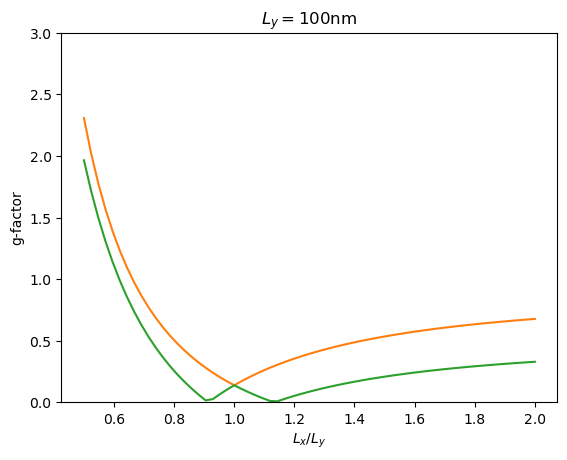

In [36]:
plt.plot(Lx_values/Ly)
plt.ylim(0,3)
plt.xlabel(r'$L_{x}/L_{y}$')
plt.ylabel('g-factor')
plt.title(r'$L_{y} = 100$nm')

#### Constant Area

In [18]:
A0 = 100e-9 * 100e-9 # Keep the are constantly at this 
Lx_range = np.linspace(50,200,64) *1e-9

def const_A_model_eval(lx):
    ly = A0/lx
    dom = RectangleDomain(Lx=lx,Ly=ly,Lz=0)
    dom.resolution = [300,300]
    gmat.independent_vars['envelope_model'].independent_vars['domain'] = dom # just update the relevant parameter
    return gmat.matrix()

INFO:aiohttp.access:127.0.0.1 [06/Aug/2023:22:20:23 +0000] "GET /__trame_vuetify/trame-vuetify.umd.min.js HTTP/1.1" 200 253 "http://localhost:46797/index.html?ui=P_0x7efff6070880_1&reconnect=auto" "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Code/1.80.2 Chrome/108.0.5359.215 Electron/22.3.14 Safari/537.36"


In [38]:
save_file = '100_fixed_A_gmat.save'

const_A_search  = None 
if os.path.exists(save_file):
    try:
        const_A_search = ParameterSearch.load(save_file)
    except Exception as err:
        print(err)

if const_A_search is None:
    const_A_search = ParameterSearch(parameter_sets = Lx_values,evaluation_function=const_A_model_eval,save_file=save_file)
const_A_search = ParameterSearch(parameter_sets = Lx_values,evaluation_function=const_A_model_eval,save_file=save_file)

In [39]:
const_A_search.run()

INFO:nqcpfem.parameter_search:evaluating at grid point 1/64
INFO:root:running build_ext
INFO:root:building 'libffcx_forms_9f66616657d27b6e5669b5fe7f97ee0a6a5abeac' extension
INFO:root:/home/oliver/miniconda3/envs/Germanium_Spins_FE/bin/x86_64-conda-linux-gnu-cc -Wno-unused-result -Wsign-compare -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /home/oliver/miniconda3/envs/Germanium_Spins_FE/include -fPIC -O2 -isystem /home/oliver/miniconda3/envs/Germanium_Spins_FE/include -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /home/oliver/miniconda3/envs/Germanium_Spins_FE/include -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /home/oliver/miniconda3/envs/Germanium_Spins_FE/include -fPIC -I/home/oliver/miniconda3/envs/Germanium_Spins_FE/lib/python3.10/site-packages/ffcx/codegeneration -I/home/oliver/miniconda3/envs/Germanium_Spins_FE/include/python3.10 -c libffcx_forms_9f66616657d27b6e5669b5fe7f97ee0a6a5abeac.c -o ./libffcx_f

unable to spin-excited state, tv distances were [0.00013568397163083514, 121978.78282430817, 121978.78282402347, 123448.3012583116, 123448.30126876572, 113177.11899376615, 113177.11899371995, 111528.57485483775, 111528.57493918717, 121078.44359718819, 111581.02541265599, 142625.15343547132]


INFO:nqcpfem.parameter_search:evaluating at grid point 4/64
INFO:root:running build_ext
INFO:root:building 'libffcx_forms_f89bd5d13b0b0a4e9ffb1a5d7192627a7485f6c2' extension
INFO:root:/home/oliver/miniconda3/envs/Germanium_Spins_FE/bin/x86_64-conda-linux-gnu-cc -Wno-unused-result -Wsign-compare -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /home/oliver/miniconda3/envs/Germanium_Spins_FE/include -fPIC -O2 -isystem /home/oliver/miniconda3/envs/Germanium_Spins_FE/include -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /home/oliver/miniconda3/envs/Germanium_Spins_FE/include -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /home/oliver/miniconda3/envs/Germanium_Spins_FE/include -fPIC -I/home/oliver/miniconda3/envs/Germanium_Spins_FE/lib/python3.10/site-packages/ffcx/codegeneration -I/home/oliver/miniconda3/envs/Germanium_Spins_FE/include/python3.10 -c libffcx_forms_f89bd5d13b0b0a4e9ffb1a5d7192627a7485f6c2.c -o ./libffcx_f

KeyboardInterrupt: 

(0.0, 3.0)

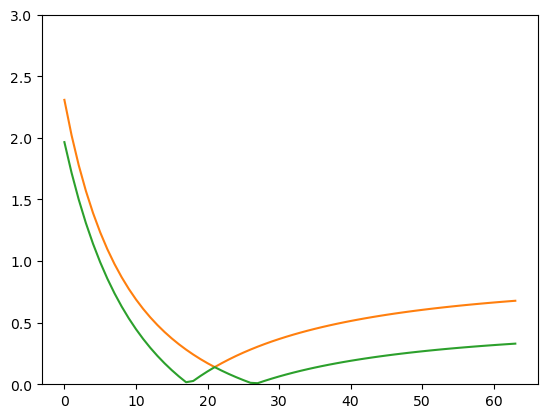

In [29]:
plt.plot(np.stack([np.linalg.svd(a)[1] for a in const_A_search._results_],axis=0))
plt.ylim(0,3)

### Actually adding B-field

In [12]:

bx = sympy.symbols('B_{x}(x)',commutative=False)
by = sympy.symbols('B_{y}(x)',commutative=False)
bz = sympy.symbols('B_{z}(x)',commutative=False)

In [ ]:
Ly = 100e-9 # 100 nm
Lx_values = np.linspace(50,200,32)*1e-9 # 50 - 200 nm 
model = FEniCsModel(band_model=bm,domain=domain,boundary_condition=0,function_class=('CG',1))
from nqcpfem.functions import SymbolicFunction
from nqcpfem.parameter_search import ParameterSearch
bx = sympy.symbols('B_{x}(x)',commutative=False)
by = sympy.symbols('B_{y}(x)',commutative=False)
bz = sympy.symbols('B_{z}(x)',commutative=False)
model.band_model.independent_vars['function_dict'][bx] = SymbolicFunction(0.5,bx)
model.band_model.independent_vars['function_dict'][by] = SymbolicFunction(0,by)
model.band_model.independent_vars['function_dict'][bz] = SymbolicFunction(0,bz)
def model_evaluation(lx):
    dom = RectangleDomain(Lx=lx,Ly=Ly,Lz=0)
    dom.resolution = [100,100]
    model.independent_vars['domain'] = dom # just update the relevant parameter
    print(lx,model.band_model.independent_vars['function_dict'][bx].expression)
    return solver.solve(model)
save_file = '100_bx_fix_y.save'

search_b  = None 
if os.path.exists(save_file):
    try:
        search_b = ParameterSearch.load(save_file)
    except Exception as err:
        print(err)

if search_b is None:
    search_b = ParameterSearch(parameter_sets = Lx_values,evaluation_function=model_evaluation,save_file=save_file)

search_b.run(save_results=True,skip_errors=False)

In [ ]:
from nqcpfem.spin_gap import find_spin_gap

gaps = [find_spin_gap(s,model) for s in search_b._results_]

In [23]:
gaps = [g[0] for g in gaps]

Text(0.5, 1.0, '$L_y = 100$nm, $B=B_{x} = 0.5T$')

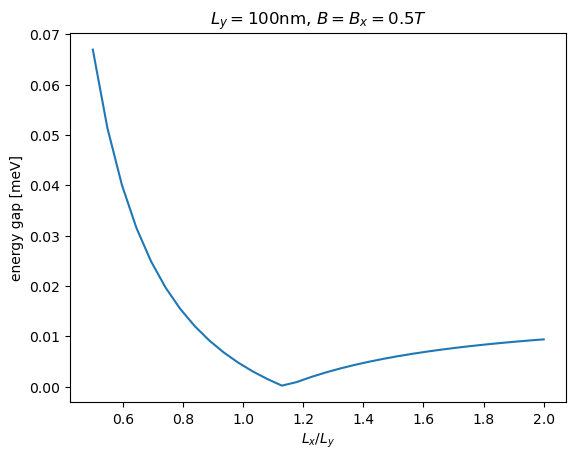

INFO:aiohttp.access:127.0.0.1 [07/Aug/2023:11:07:38 +0000] "GET /__trame_vuetify/fonts/roboto-latin-400.1e2d4d3a.woff2 HTTP/1.1" 200 239 "http://localhost:44515/__trame_vuetify/trame-vuetify.css" "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Code/1.80.2 Chrome/108.0.5359.215 Electron/22.3.14 Safari/537.36"


In [30]:
plt.plot(Lx_values/Ly,np.array(gaps)*nqcpfem.UNIT_CONVENTION['J to eV']*1000)
plt.ylabel('energy gap [meV]')
plt.xlabel('$L_x/L_y$')
plt.title(r'$L_y = 100$nm, $B=B_{x} = 0.5T$')

0.500000000000000


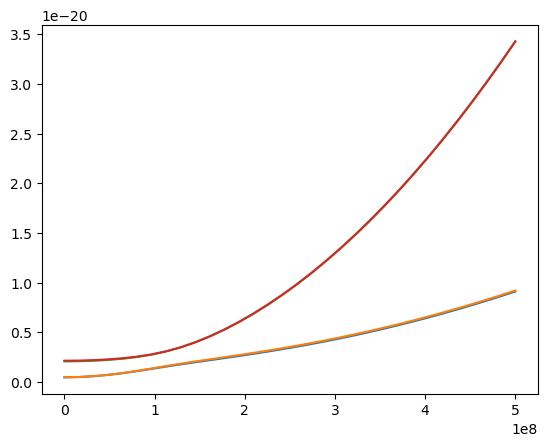

In [19]:
from nqcpfem.functions import SymbolicFunction
bm.independent_vars['function_dict'][bx] = SymbolicFunction(0.5,bx)
bm.independent_vars['function_dict'][by] = SymbolicFunction(0,by)
bm.independent_vars['function_dict'][bz] = SymbolicFunction(0,bz)
print(bm.independent_vars['function_dict'][bx].expression)
s=bm.spectrum((0,5e8),(1,0),32)
plt.plot(*s)

⎡⎡⎡            2      2               2      2        2             2         
⎢⎢⎢\gamma_{1}⋅h̅ ⋅k_{x}    \gamma_{1}⋅h̅ ⋅k_{y}    0.5⋅π ⋅\gamma_{1}⋅h̅    \ga
⎢⎢⎢──────────────────── + ──────────────────── + ──────────────────── + ──────
⎢⎢⎢        2⋅m                    2⋅m                      2                  
⎢⎣⎣                                                     l_z ⋅m                
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                 [[0]]       
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢       ⎡⎡                 2      2                 

Replace $k_{i}^2$ with $\pi^2/L_{i}^2$ and $k_i$ with 0

# Comparing With Analytical Ansatz

In [8]:

bm = LuttingerKohnHamiltonian(spatial_dim=3).material_spec('Ge').add_z_confinement(1,'box',25e-9)
bm.post_processed_array().subs({'\hbar':'hbar'})

⎡⎡⎡            2      2               2      2        2             2         
⎢⎢⎢\gamma_{1}⋅h̅ ⋅k_{x}    \gamma_{1}⋅h̅ ⋅k_{y}    0.5⋅π ⋅\gamma_{1}⋅h̅    \ga
⎢⎢⎢──────────────────── + ──────────────────── + ──────────────────── + ──────
⎢⎢⎢        2⋅m                    2⋅m                      2                  
⎢⎣⎣                                                     l_z ⋅m                
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                 [[0]]       
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢       ⎡⎡                 2      2                 

In [9]:
kx,ky,kz = bm.momentum_symbols
Lx,Ly,Lz = sympy.symbols('l_x,l_y,l_z')
#Lx = 100e-9
#Ly = 100e-9
#Lz = 25e-9
ksq = {'x': np.pi**2/Lx**2,'y':np.pi**2/Ly**2,'z':np.pi**2/Lz**2}

substituter = lambda a: a.subs(kx**2,ksq['x']).subs(ky**2,ksq['y']).subs(kz**2,ksq['z']).subs({kx:0,ky:0,kz:0})

substituter(bm.post_processed_array().subs({'\hbar':'hbar'}))

⎡⎡⎡     2             2                                2                      
⎢⎢⎢0.5⋅π ⋅\gamma_{1}⋅h̅    4.93480220054468⋅\gamma_{1}⋅h̅    4.93480220054468⋅
⎢⎢⎢──────────────────── + ────────────────────────────── + ───────────────────
⎢⎢⎢          2                           2                               2    
⎢⎣⎣       l_z ⋅m                      l_y ⋅m                           lₓ ⋅m  
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                   

In [10]:
A = substituter(sympy.Array(bm.numerical_array()))
A_gen = sympy.lambdify((Lx,Ly,Lz),A)
A

⎡⎡⎡                      2   1.0615463949734e-36   1.0615463949734e-36⎤⎤      
⎢⎢⎢4.78574322294494e-23⋅π  + ─────────────────── + ───────────────────⎥⎥      
⎢⎢⎢                                     2                    2        ⎥⎥      
⎢⎣⎣                                  l_y                   lₓ         ⎦⎦      
⎢                                                                             
⎢                                                                         ⎡⎡  
⎢                                                                         ⎢⎢2.
⎢                                 [[0]]                                   ⎢⎢  
⎢                                                                         ⎣⎣  
⎢                                                                             
⎢          ⎡⎡2.5544589754184e-37⋅√3   2.5544589754184e-37⋅√3⎤⎤                
⎢          ⎢⎢────────────────────── - ──────────────────────⎥⎥                
⎢          ⎢⎢            2                       2  

In [11]:
lz = 25e-9
ly = 100e-9
evals = []
lx_vals=np.linspace(50e-9,200e-9,64)
for lx in lx_vals:
    evals.append(np.linalg.eig(np.array(A_gen(lx,ly,lz)).astype('complex')[:,:,0,0])[0])

  return np.asarray(x, float)



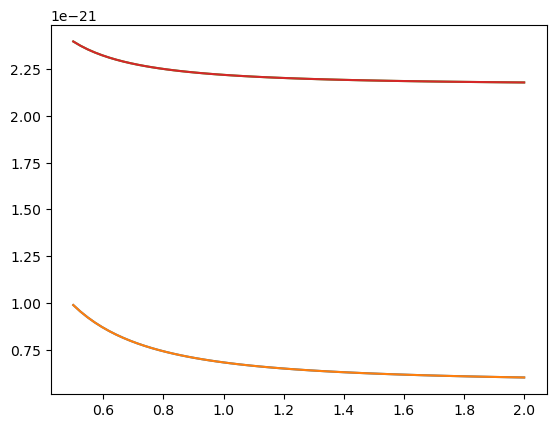

In [12]:
eig_vals = np.sort(np.stack(evals),axis=1)
plt.plot(lx_vals/ly,eig_vals)

In [19]:
import dolfinx
def ansatz_maker(model,ev_n=0):
    lx = model.domain.Lx
    ly = model.domain.Ly
    lz = model.domain.Lz
    lk_A = A_gen(lx,ly,lz)
    lk_vector = np.linalg.eigh(lk_A)[1][:,ev_n]
    def ansatz(x):
        x_part = model.length_scale()/(np.sqrt(lx*ly))*np.sin(np.pi/lx*(x[0]*model.length_scale()-lx/2))*np.sin(np.pi/ly*(x[1]*model.length_scale()-ly/2))
        lk_l = [l*x_part for l in lk_vector]
        return np.stack(lk_l,axis=0)
        
        
    func = dolfinx.fem.Function(model.function_space())
    func.interpolate(ansatz)
    
    func_arr = model.eigensolutions_to_eigentensors(func.x.array)
    return func_arr
    

    

In [20]:
domain = RectangleDomain(100e-9,50e-9,25e-9)

domain.resolution = [100,100]
model = FEniCsModel(bm,domain,0,('CG',1))

observable = model.construct_observable(np.eye(4).reshape(4,4,1,1))


In [21]:
LOGGER = logging.getLogger()
def projection_study(lx):
    proj = [[],[],[],[]]
    solutions = []
    domain = RectangleDomain(lx,100e-9,25e-9)
    domain.resolution = [100,100]
    model.independent_vars['domain'] = domain
    observable = model.construct_observable(np.eye(4).reshape(4,4,1,1))
    
    sols = solver.solve(model)
    for i in range(4):
        f = ansatz_maker(model,i)
        f_proj = [observable.mel(f,s) for s in sols[1]]
        proj[i].append(f_proj)
    
    solutions.append(sols)
        
    return proj,solutions

In [22]:

from nqcpfem.parameter_search import ParameterSearch
projection_save = 'ansat_projection.save'
projections = ParameterSearch(np.linspace(50e-9,200e-9,64),projection_study,projection_save)



In [23]:
projections.run(True,False)

INFO:nqcpfem.parameter_search:evaluating at grid point 1/64
INFO:nqcpfem.parameter_search:evaluating at grid point 2/64
INFO:nqcpfem.parameter_search:evaluating at grid point 3/64
INFO:nqcpfem.parameter_search:evaluating at grid point 4/64
INFO:nqcpfem.parameter_search:evaluating at grid point 5/64
INFO:nqcpfem.parameter_search:evaluating at grid point 6/64
INFO:nqcpfem.parameter_search:evaluating at grid point 7/64
INFO:nqcpfem.parameter_search:evaluating at grid point 8/64
INFO:nqcpfem.parameter_search:evaluating at grid point 9/64
INFO:nqcpfem.parameter_search:evaluating at grid point 10/64
INFO:nqcpfem.parameter_search:evaluating at grid point 11/64
INFO:nqcpfem.parameter_search:evaluating at grid point 12/64
INFO:nqcpfem.parameter_search:evaluating at grid point 13/64
INFO:nqcpfem.parameter_search:evaluating at grid point 14/64
INFO:nqcpfem.parameter_search:evaluating at grid point 15/64
INFO:nqcpfem.parameter_search:evaluating at grid point 16/64
INFO:nqcpfem.parameter_search:eva

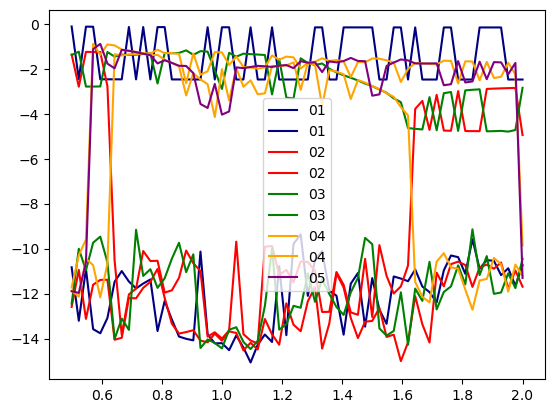

In [30]:
colors = ['navy','red','green','orange','purple']
ls = ['-','--','-.',':']
L=[np.array(r[0])[:,0,:10] for r in projections._results_]
results = np.stack(L)
results = np.log10(np.abs(L))
for i in range(4):
    if i:
        continue
    for j in range(6):
        y_val = np.sort(results[:,i,2*j-1:2*j+1],axis=1)
        c = colors[j-1]
        n = str(i) +str(j)
        l = ls[i]
        plt.plot(projections.parameter_sets/100e-9,y_val,ls=l,color=c,label=n)
        
plt.legend()
    




In [ ]:
results.shape

(8, 4, 10)